In [4]:
%reload_ext nb_black
from matplotlib import pyplot as plt
import plotly
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests

%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats

from tqdm.notebook import tqdm as status

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
def calc_non_param_ci(x1, x2, alpha=0.05):
    """Calc confidence interval for 2 group median test

    Process:
      * Find all pairwise diffs
      * Sort diffs
      * Find appropriate value of k
      * Choose lower bound from diffs as: diffs[k]
      * Choose upper bound from diffs as: diffs[-k]

    Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2545906/

    :param x1: sample 1
    :param x2: sample 2
    :param alpha: significance level
    :return: (tuple) confidence interval bounds
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    n1 = x1.size
    n2 = x2.size
    cv = stats.norm.ppf(1 - alpha / 2)

    # Find pairwise differences for every datapoint in each group
    diffs = (x1[:, None] - x2).flatten()
    diffs.sort()

    # For an approximate (1-a)% confidence interval first calculate K:
    k = int(round(n1 * n2 / 2 - (cv * (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5)))

    # The Kth smallest to the Kth largest of the n x m differences
    # n1 and n2 should be > ~20
    ci_lo = diffs[k]
    ci_hi = diffs[-k]

    return ci_lo, ci_hi


def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles


def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# import dataset and dictionary for the data
df = pd.read_csv("data/train_data.csv")
df_dict = pd.read_csv("data/train_data_dictionary.csv")
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preliminary Exploration

*The first set of test variables are consistent across regions
*further analysis could be done for performance  across different regions on similar patient types 

**Test variables:**
- Age
- Type of Admission
- severity of Illness
- Admission_Deposit
- Bed Grade
- Hospital type code

In [7]:
#  save the df with only the fields of interest
df = df[
    [
        "case_id",
        "Bed Grade",
        "patientid",
        "Type of Admission",
        "Severity of Illness",
        "Visitors with Patient",
        "Age",
        "Admission_Deposit",
        "Stay",
    ]
]

# set index to case_id
df = df.set_index("case_id", inplace=False)

# rename columns so they're easier to work with
df = df.rename(
    columns={
        "Bed Grade": "bed_grade",
        "Type of Admission": "admission_type",
        "Severity of Illness": "severity",
        "Visitors with Patient": "visitors",
        "Age": "age",
        "Admission_Deposit": "deposit",
        "Stay": "stay",
    },
    inplace=False,
)

df.head()

,bed_grade,patientid,admission_type,severity,visitors,age,deposit,stay
case_id,,,,,,,,
1,2.0,31397,Emergency,Extreme,2,51-60,4911.0,0-10
2,2.0,31397,Trauma,Extreme,2,51-60,5954.0,41-50
3,2.0,31397,Trauma,Extreme,2,51-60,4745.0,31-40
4,2.0,31397,Trauma,Extreme,2,51-60,7272.0,41-50
5,2.0,31397,Trauma,Extreme,2,51-60,5558.0,41-50


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print("table info...\n")
print(df.info())
print("\n# of unique patientids...")
df.patientid.nunique()

table info...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318438 entries, 1 to 318438
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bed_grade       318325 non-null  float64
 1   patientid       318438 non-null  int64  
 2   admission_type  318438 non-null  object 
 3   severity        318438 non-null  object 
 4   visitors        318438 non-null  int64  
 5   age             318438 non-null  object 
 6   deposit         318438 non-null  float64
 7   stay            318438 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 21.9+ MB
None

# of unique patientids...


92017

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# more than 100 days needs to be changed to a different value to be converted to numeric
df.age.value_counts()

41-50     63749
31-40     63639
51-60     48514
21-30     40843
71-80     35792
61-70     33687
11-20     16768
81-90      7890
0-10       6254
91-100     1302
Name: age, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*  **The object data type for age and stay need to be converted to a numeric to represent each group.**

In [10]:
# set all stay values of "More than 100 Days" to 100 numeric
# over_100 = df.stay == "More than 100 Days"
df.loc[df.stay == "More than 100 Days", "stay"] = 100
# df[df.stay == 100]


# stay column converted to number value
stay_slice = (pd.to_numeric(df.stay.str.slice(0, 1)) * 10) + 5
df.stay = stay_slice

# age column converted to number value
age_slice = (pd.to_numeric(df.age.str.slice(0, 1)) * 10) + 5
df.age = age_slice

df.head()

,bed_grade,patientid,admission_type,severity,visitors,age,deposit,stay
case_id,,,,,,,,
1,2.0,31397,Emergency,Extreme,2,55,4911.0,5.0
2,2.0,31397,Trauma,Extreme,2,55,5954.0,45.0
3,2.0,31397,Trauma,Extreme,2,55,4745.0,35.0
4,2.0,31397,Trauma,Extreme,2,55,7272.0,45.0
5,2.0,31397,Trauma,Extreme,2,55,5558.0,45.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
#  checking for nulls after the string replacements
print("Null value counts...")
print(df.stay.isnull().value_counts())

#  when I was converting the stay values to numeric, the 100+ values converted to NaN
#  replacing all NaN values with 100
df.dropna(inplace=True)

Null value counts...
False    311755
True       6683
Name: stay, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
df.head()

,bed_grade,patientid,admission_type,severity,visitors,age,deposit,stay
case_id,,,,,,,,
1,2.0,31397,Emergency,Extreme,2,55,4911.0,5.0
2,2.0,31397,Trauma,Extreme,2,55,5954.0,45.0
3,2.0,31397,Trauma,Extreme,2,55,4745.0,35.0
4,2.0,31397,Trauma,Extreme,2,55,7272.0,45.0
5,2.0,31397,Trauma,Extreme,2,55,5558.0,45.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
#  checking for nulls after the string replacements
print("\nNull value counts after fill...")
print(df.stay.isnull().value_counts())


Null value counts after fill...
False    311644
Name: stay, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# unique values for severity and admission type fields to be used to break into groups
print("Unique severity values...")
print(df.severity.unique())
print("\nUnique admission types...")
print(df.admission_type.unique())

print("\nAge groups...")
print(df.age.unique())

Unique severity values...
['Extreme' 'Moderate' 'Minor']

Unique admission types...
['Emergency' 'Trauma' 'Urgent']

Age groups...
[55 75 35 45 85 65 25 15  5 95]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
pd.options.display.max_rows = 90

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
df.groupby(["age", "severity", "admission_type"]).agg(
    {"stay": ["median", "mean", "count"]}
).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Preliminary Analysis:**
* trauma in each group tends to have the highest average stay regardless of admission type or age
* youngest age group with extreme severity of any admission type has a higher average stay
* starting at ages 55-65+ anything moderate or extreme results on average in a higher length of stay
* within each age group, severity looks to play a significantly greater role in determining a higher avg stay length
* admission type looks to have a small relationship to higher stay lengths
* ages 35-55 seem to show the highest incidence of visit counts, mainly of moderate/emergency trauma & the same pattern looks to trail off at age groups to either side

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311644 entries, 1 to 318438
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bed_grade       311644 non-null  float64
 1   patientid       311644 non-null  int64  
 2   admission_type  311644 non-null  object 
 3   severity        311644 non-null  object 
 4   visitors        311644 non-null  int64  
 5   age             311644 non-null  int64  
 6   deposit         311644 non-null  float64
 7   stay            311644 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 31.4+ MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Admission Type

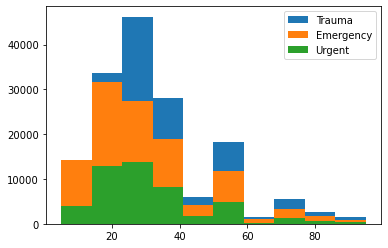

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# creating groups for each admission type
trauma = df[df.admission_type == "Trauma"]
emergency = df[df.admission_type == "Emergency"]
urgent = df[df.admission_type == "Urgent"]

#  plot histogram of each admission group
plt.hist(trauma.stay, label="Trauma")
plt.hist(emergency.stay, label="Emergency")
plt.hist(urgent.stay, label="Urgent")

plt.legend()
plt.show()

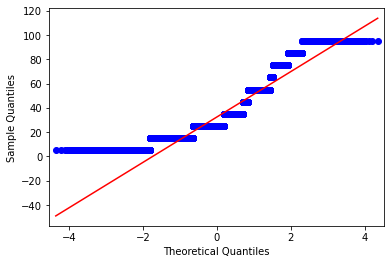

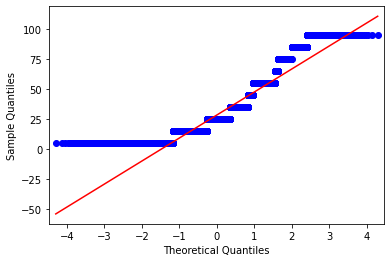

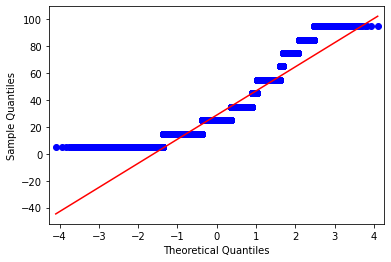

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
qqplot(trauma.stay, line="s")
plt.show()
qqplot(emergency.stay, line="s")
plt.show()
qqplot(urgent.stay, line="s")
plt.show()

**Jarque-Bera Test**
* probability that kurtosis and skewness matches that of a noraml distribution

H_o = both match that of a normal distribution

In [20]:
#  testing for kurtosis/skewness normality
print("trauma")
t, p = stats.jarque_bera(trauma.stay)
print(p)
print("emergency")
t, p = stats.jarque_bera(emergency.stay)
print(p)
print("urgent")
t, p = stats.jarque_bera(urgent.stay)
print(p)

trauma
0.0
emergency
0.0
urgent
0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** null hypothesis is rejected; data is not normally distributed

**Kruskal-Wallis Test**

H_o = none of the group medians are significantly different

In [21]:
t, p = stats.kruskal(trauma.stay, emergency.stay, urgent.stay)
p < 0.05

True

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** null hypothesis that the medians are the same is rejected

**Kruskal pair testing**

In [22]:
p_vals = []

# run kruskal test on each pair of groups and add to list of uncorrected p-values
t, p = stats.kruskal(trauma.stay, emergency.stay)
p_vals.append(p)
t, p = stats.kruskal(trauma.stay, urgent.stay)
p_vals.append(p)
t, p = stats.kruskal(emergency.stay, urgent.stay)
p_vals.append(p)

reject, p_corrected, _, corrected_alpha = multipletests(p_vals, method="bonferroni")
print(reject)
print(p_corrected)
print(corrected_alpha)

[ True  True  True]
[0.00000000e+00 0.00000000e+00 3.78133696e-22]
0.016666666666666666


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** After the correction, the null hypotheses that the medians are all the same can be rejected

## **Post hoc effect size analysis**

### **Confidence interval for 2 group median test**

**Trauma vs. Urgent confidence interval**

In [23]:
median_diffs = []
# random sample of each group
for i in status(range(5000)):
    trauma_sample = trauma.stay.sample(frac=1.0, replace=True)
    #     emergency_sample = emergency.stay.sample(frac=1.0, replace=True)
    urgent_sample = urgent.stay.sample(frac=1.0, replace=True)
    urgent_median = urgent_sample.median()
    #     non_trauma_median = (emergency_sample.median() + urgent_sample.median()) / 2
    trauma_median = trauma_sample.median()
    median_diff = trauma_median - urgent_median
    median_diffs.append(median_diff)

# calculate the 95% confidence interval of the bootstrapped differences of mean with np.percentile()
ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)
print("Trauma vs. Urgent")
print(f"Bootstrapped confidence interval: {ci_lo}, {ci_hi}")


Trauma vs. Urgent
Bootstrapped confidence interval: 0.0, 0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** The confidence interval between median difference of trauma and urgent is 0. There is essentially 0 effect size.

**Trauma vs. Emergency confidence interval**

In [24]:
median_diffs = []
# random sample of each group
for i in status(range(5000)):
    trauma_sample = trauma.stay.sample(frac=1.0, replace=True)
    emergency_sample = emergency.stay.sample(frac=1.0, replace=True)
    emergency_median = emergency_sample.median()
    #     urgent_sample = urgent.stay.sample(frac=1.0, replace=True)
    #     urgent_median = urgent_sample.median()
    #     non_trauma_median = (emergency_sample.median() + urgent_sample.median()) / 2
    trauma_median = trauma_sample.median()
    median_diff = trauma_median - emergency_median
    median_diffs.append(median_diff)

# calculate the 95% confidence interval of the bootstrapped differences of mean with np.percentile()
ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)
print("Trauma vs. Emergency")
print(f"Bootstrapped confidence interval: {ci_lo}, {ci_hi}")


Trauma vs. Emergency
Bootstrapped confidence interval: 0.0, 0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** The confidence interval between median difference of trauma and urgent is 0. There is essentially 0 effect size.

### **Common language effect size test**

**CLES test: Trauma vs. Urgent**

In [25]:
# 50% sample size of each group
trauma_sample = trauma.stay.sample(frac=0.5, replace=True)
urgent_sample = urgent.stay.sample(frac=0.5, replace=True)

# CLES test for trauma vs. urgent
cles_ind(trauma_sample, urgent_sample)

0.4607461491367074

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** When admitting a patient as **trauma**, 46% of the time we would expect a longer stay than if they were admitted as **urgent**. 

**CLES Test: Trauma vs. Emergency**

In [26]:
#  new 25% sample of trauma and emergency groups
trauma_sample = trauma.stay.sample(frac=0.25, replace=True)
emergency_sample = emergency.stay.sample(frac=0.25, replace=True)

# CLES for trauma vs. emergency
cles_ind(trauma_sample, emergency_sample)

0.4780300786791433

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** When admitting a patient as **trauma**, 48% of the time we would expect a longer stay than if they were admitted as **emergency**. 

**CLES Test: Emergency vs. Urgent**

In [27]:
# 50% samples of emergency and urgent groups
emergency_sample = emergency.stay.sample(frac=0.5, replace=True)
urgent_sample = urgent.stay.sample(frac=0.5, replace=True)

#  CLES test for emergency vs. urgent
cles_ind(emergency_sample, urgent_sample)

0.41556759613026806

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** When admitting a patient as **emergency**, 42% of the time we would expect a longer stay than if they were admitted as **urgent**

**Conclusion:** Even though we were able to reject the null hypothesis that the group medians are the same, but the confidence interval for the size of the effect is 0.

# Age vs. LOS

In [28]:
moderate = df[df.severity == "Moderate"]
minor = df[df.severity == "Minor"]
extreme = df[df.severity == "Extreme"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Minor severity**

In [29]:
minor.groupby(["age"]).agg({"stay": ["mean", "count"]}).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Moderate severity**

In [30]:
moderate.groupby(["age"]).agg({"stay": ["mean", "count"]}).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Extreme severity**

In [31]:
extreme.groupby(["age"]).agg({"stay": ["mean", "count"]}).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

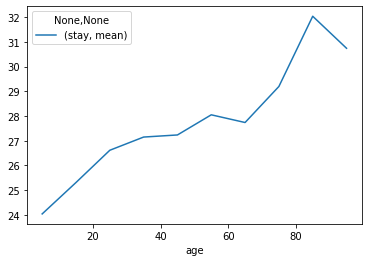

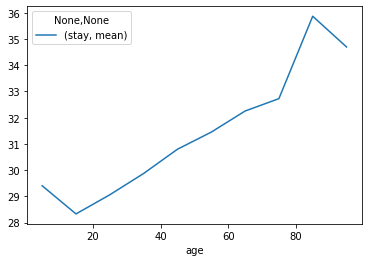

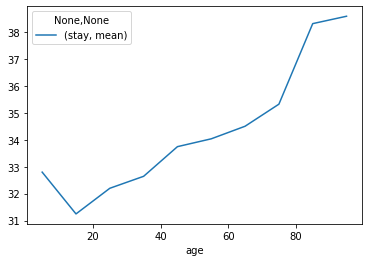

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
minor_agg = minor.groupby(["age"]).agg({"stay": ["mean"]})
moderate_agg = moderate.groupby(["age"]).agg({"stay": ["mean"]})
extreme_agg = extreme.groupby(["age"]).agg({"stay": ["mean"]})

minor_agg.plot()
moderate_agg.plot()
extreme_agg.plot()

**Analysis:** 
* Between the aggregate mean table and the line plot, there seems to be a definite correlation between age and length of stay.
* there does seem to be more of a correlation in the minor and moderate groups than in the extreme group

**Correlation coefficients**

In [33]:
print("Minor")
print(stats.pearsonr(minor.age, minor.stay))
print("Moderate")
print(stats.pearsonr(moderate.age, moderate.stay))
print("Extreme")
print(stats.pearsonr(extreme.age, extreme.stay))

Minor
(0.07056266314133419, 3.766795192972117e-94)
Moderate
(0.075292102384955, 1.1354832776736747e-214)
Extreme
(0.05987691272507544, 1.165543385469099e-44)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Bottom 20th percentile for age

### Moderate

In [34]:
#  find 20th percentile of age range
np.percentile(moderate.age, 20)

35.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# create 2 groups
bottom_20 = df[df.age <= 35]
top_80 = df[df.age > 35]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Normality checks**

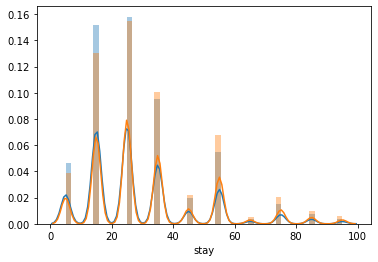

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
sns.distplot(bottom_20.stay)
sns.distplot(top_80.stay)

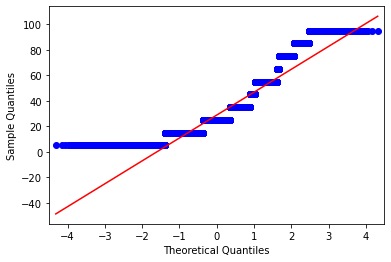

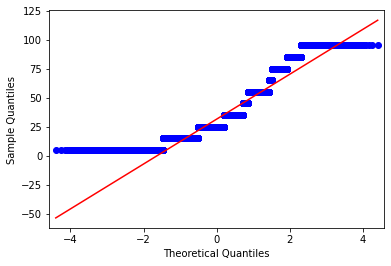

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# qqplots for both groups length of stay
qqplot(bottom_20.stay, line="s")
plt.show()
qqplot(top_80.stay, line="s")
plt.show()

**Jarque-Bera Test**

H_null = the kurtosis and skewness match that of a normal distribution

In [38]:
t, p = stats.jarque_bera(bottom_20.stay)
print("reject null: " + str(p < 0.05))

t, p = stats.jarque_bera(top_80.stay)
print("reject null: " + str(p < 0.05))

reject null: True
reject null: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* both groups do not match the kurtosis and skewness of a normal distribution

**Kruskal-Wallis Test**

H_null = the medians of both groups are the same

In [39]:
t, p = stats.kruskal(bottom_20.stay, top_80.stay)
print("reject null: " + str(p < 0.05))

reject null: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* the medians of both groups are significantly different

In [40]:
median_diffs = []
for i in status(range(5000)):
    bottom_sample = bottom_20.stay.sample(frac=1.0, replace=True)
    top_sample = top_80.stay.sample(frac=1.0, replace=True)
    median_diff = bottom_sample.median() - top_sample.median()
    median_diffs.append(median_diff)

ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)
print(f"Bottom 20th percentile confidence interval: {ci_lo}, {ci_hi}")


Bottom 20th percentile confidence interval: 0.0, 0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** 
* moderate severity group
* The median confidence interval for the bottom 20th age percentile is 0.0

**Common language effect size**

In [41]:
# 25% sample size of each group
bottom_sample = bottom_20.stay.sample(frac=0.25, replace=True)
top_sample = top_80.stay.sample(frac=0.25, replace=True)

# CLES test for trauma vs. urgent
cles_ind(bottom_sample, top_sample)

0.4435827776874105

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** 44% of the time when a patient in the bottom 20th age percentile is admitted with a moderate condition they will have a shorter length of stay

## Top 20th percentile for age

In [42]:
#  find 20th percentile of age range
np.percentile(moderate.age, 80)

65.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# create 2 groups
top_20 = df[df.age >= 65]
bottom_80 = df[df.age < 65]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Normality Checks**

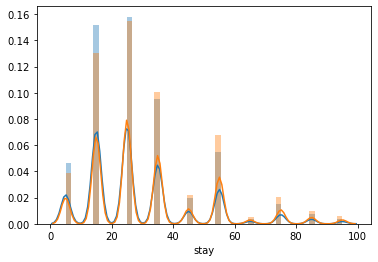

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
sns.distplot(bottom_20.stay)
sns.distplot(top_80.stay)

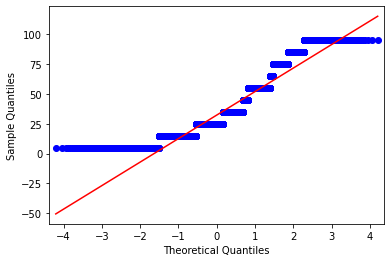

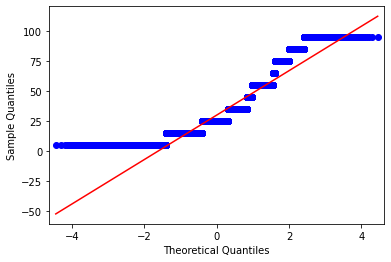

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
# qqplots for both groups length of stay
qqplot(top_20.stay, line="s")
plt.show()
qqplot(bottom_80.stay, line="s")
plt.show()

**Jarque-Bera Test**

H_null = the distributions match that of a normal distribution

In [46]:
t, p = stats.jarque_bera(top_20.stay)
print("reject null: " + str(p < 0.05))

t, p = stats.jarque_bera(bottom_80.stay)
print("reject null: " + str(p < 0.05))

reject null: True
reject null: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Kruskal-Wallis Test**

H_null = the medians of both groups are the same

In [47]:
t, p = stats.kruskal(top_20.stay, bottom_80.stay)
print("reject null: " + str(p < 0.05))

reject null: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* the medians for both groups are statistically different

In [48]:
median_diffs = []
for i in status(range(5000)):
    top_sample = top_20.stay.sample(frac=1.0, replace=True)
    bottom_sample = bottom_80.stay.sample(frac=1.0, replace=True)
    median_diff = top_sample.median() - bottom_sample.median()
    median_diffs.append(median_diff)

ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)
print(f"Top 20th percentile confidence interval: {ci_lo}, {ci_hi}")


Top 20th percentile confidence interval: 0.0, 0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** 
* moderate severity group
* The median confidence interval for the top 20th age percentile is 0.0

**Common language effect size**

In [49]:
# 25% sample of both groups
top_sample = top_20.stay.sample(frac=0.25, replace=True)
bottom_sample = bottom_80.stay.sample(frac=0.25, replace=True)

cles_ind(top_sample, bottom_sample)

0.44221043889985956

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** 44% of the time when a patient in the top 20th percentile for age is admitted with a moderate condition, they will have a longer length of stay.

# Bed grade vs. LOS

In [50]:
minor.groupby("bed_grade").agg({"stay": ["mean", "count"]}).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* it looks like in minor cases there may be some relationship between stay length and bed grade

In [51]:
moderate.groupby("bed_grade").agg(
    {"stay": ["mean", "count"]}
).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
extreme.groupby("bed_grade").agg(
    {"stay": ["mean", "count"]}
).style.background_gradient()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Minor

In [53]:
# 2 groups for the lower (1-2) and higher (3-4) bed grades
low = minor[minor.bed_grade < 3]
hi = minor[minor.bed_grade > 2]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

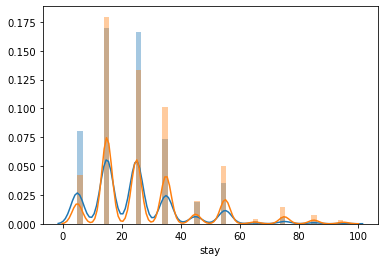

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# plot distributions for both groups
sns.distplot(low.stay)
sns.distplot(hi.stay)
plt.show()

* just like the other groups these don't appear to be normally distributed

**Kruskal-Wallis Test**

h_null = the medians for both groups are the same

In [55]:
t, p = stats.kruskal(low.stay, hi.stay)
print("reject null: " + str(p < 0.05))

reject null: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Median confidence interval**

In [56]:
median_diffs = []
for i in status(range(10000)):
    low_sample = low.stay.sample(frac=1.0, replace=True)
    hi_sample = hi.stay.sample(frac=1.0, replace=True)
    median_diff = hi_sample.median() - low_sample.median()
    median_diffs.append(median_diff)

ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)
print(f"Top 20th percentile confidence interval: {ci_lo}, {ci_hi}")


Top 20th percentile confidence interval: 0.0, 0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:**
* groups for bed grades 1-2 and 3-4
* The median confidence interval for the difference in stay length is 0.0



**Common language effect size**

In [57]:
low_sample = low.stay.sample(frac=1.0, replace=True)
hi_sample = hi.stay.sample(frac=1.0, replace=True)

cles_ind(low_sample, hi_sample)

0.4548519116443801

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Analysis:** 46% of the time when a person is admitted to room with a bed grade of 1-2 for a minor condition, they will experience a shorter length of stay.